# Note: Execute Lvl 4.1 only after PROMO Analysis, as it uses the promo_genes for evaluation

In [1]:
# https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, LeaveOneOut
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix, plot_precision_recall_curve, classification_report

from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from tqdm.notebook import tqdm

plt.style.use('seaborn-whitegrid')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
import gc
import time
import copy
import torch
import model_utils as u
import model_evaluation as me

In [6]:
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":16:8"

In [7]:
import warnings
warnings.simplefilter('ignore')

In [8]:
# https://pytorch.org/docs/stable/notes/randomness.html
seed = 322
u.set_all_seeds(seed)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

---
---
---

In [10]:
PATH = "D:/CANCER BIOLOGY/DATASET/TCGA/FROM Xena/"

In [11]:
# https://stackoverflow.com/questions/18885175/read-a-zipped-file-as-a-pandas-dataframe
# https://www.analyticsvidhya.com/blog/2021/04/delimiters-in-pandas-read_csv-function/

df_luad = pd.read_csv(PATH+"TCGA.LUAD.sampleMap_HiSeqV2_PANCAN.gz", compression = "gzip", sep = "\t")
df_lusu = pd.read_csv(PATH+"TCGA.LUSC.sampleMap_HiSeqV2_PANCAN.gz", compression = "gzip", sep = "\t")

In [12]:
df_luad

,sample,TCGA-69-7978-01,TCGA-62-8399-01,TCGA-78-7539-01,TCGA-50-5931-11,TCGA-73-4658-01,TCGA-44-6775-01,TCGA-44-2655-01,TCGA-44-3398-01,TCGA-62-8397-01,...,TCGA-75-7025-01,TCGA-55-7726-01,TCGA-L9-A743-01,TCGA-86-8358-01,TCGA-55-6972-01,TCGA-55-7727-01,TCGA-91-6831-01,TCGA-MN-A4N4-01,TCGA-55-8302-01,TCGA-MP-A4TK-01
0,ARHGEF10L,0.125808,0.561708,-0.237592,-1.180492,-0.656192,0.139908,-0.537692,-0.839092,0.677108,...,0.226508,-2.342092,-0.207692,-0.659792,-1.651292,-2.621192,-1.025192,0.070108,0.305608,0.263208
1,HIF3A,-1.294926,6.069174,3.581474,3.927674,-0.525926,-1.497426,-0.021226,0.179974,1.092974,...,2.539674,-1.259526,-0.387226,3.689474,3.509374,1.986874,-1.993426,2.790974,-0.018326,4.657474
2,RNF17,-0.112935,-0.531035,0.592065,0.291065,-0.531035,0.475865,0.071065,-0.531035,-0.531035,...,-0.068235,-0.531035,0.428265,0.202865,0.567665,0.408165,-0.531035,0.440465,-0.531035,0.049365
3,RNF10,-1.411872,-0.228672,-0.108372,-0.043472,-0.156672,-0.605472,0.139328,-0.450172,0.583528,...,-0.451572,0.261228,-0.331772,-0.213372,-0.189472,0.091028,0.492828,0.037428,0.003728,-0.334572
4,RNF11,0.203922,0.052122,-0.499978,0.710822,0.373522,0.129022,0.436522,0.529622,0.314922,...,-0.155778,0.362522,-0.520578,0.031222,-0.966478,0.318322,0.150822,-0.357778,-0.451578,0.156422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20525,PTRF,0.863614,0.317114,-1.243086,2.802714,1.110714,0.879814,-0.028286,0.008714,-0.005186,...,0.544614,1.638214,0.381814,-1.080186,-2.139886,-1.495486,0.472314,0.993014,0.634014,1.222714
20526,BCL6B,0.802173,1.079073,-1.283227,2.250473,1.513973,0.126473,0.576073,0.643573,-0.735227,...,0.842873,0.680873,0.642773,0.154673,-0.849427,-0.359227,0.332973,0.570873,-0.909527,0.671573
20527,GSTK1,0.108205,-0.782695,0.034105,-0.540795,-0.454095,-0.797795,0.531305,0.310605,0.204105,...,-0.454195,-0.466595,-0.011995,-0.503195,0.512405,-0.584495,-1.756895,0.506805,-0.114895,-0.189095
20528,SELP,0.595367,3.114267,0.571467,3.985967,2.893167,1.805567,2.445467,2.575967,1.336567,...,2.817667,-0.301333,2.508367,-0.518033,-1.540033,1.663867,-0.275933,-0.073933,0.848867,1.195667


---
---

In [13]:
# ## prepare km plotter dataset

# # df_plotter = u.prepare_km_plotter_dataset(df_luad, df_lusu)
# df_luad.set_index('sample', inplace=True)
# df_lusu.set_index('sample', inplace=True)

In [14]:
# df_luad = df_luad.T
# df_lusu = df_lusu.T

In [15]:
# df_luad

In [16]:
# promo_genes = u.read_promo_genes(PATH)

In [17]:
# survival_luad = pd.read_csv(PATH+'survival_LUAD_survival.txt', sep='\t')
# survival_lusu = pd.read_csv(PATH+'survival_LUSC_survival.txt', sep='\t')

In [18]:
# survival_luad

In [19]:
# survival_lusu

In [20]:
# survival_lusu.rename(columns={'xena_sample':'sample'}, inplace=True)

In [21]:
# survival_lusu

In [22]:
# survival_luad.drop(columns=['_PATIENT','DSS', 'DFI', 'DFI.time', 'PFI', 'PFI.time', 'Redaction'], inplace=True)
# survival_lusu.drop(columns=['_PATIENT','DSS', 'DFI', 'DFI.time', 'PFI', 'PFI.time', 'Redaction'], inplace=True)

In [23]:
# survival_luad

In [24]:
# survival_lusu

In [25]:
# df_luad = df_luad[df_luad.columns.intersection(promo_genes)]

In [26]:
# df_lusu = df_lusu[df_lusu.columns.intersection(promo_genes)]

In [27]:
# df_luad

In [28]:
# df_lusu

In [29]:
# df_luad.reset_index(inplace=True)
# df_lusu.reset_index(inplace=True)

In [30]:
# df_luad.rename(columns={'index':'sample'}, inplace=True)
# df_lusu.rename(columns={'index':'sample'}, inplace=True)

In [31]:
# final_df_luad = pd.merge(df_luad, survival_luad, how='inner', on=['sample'])

In [32]:
# final_df_luad

In [33]:
# final_df_lusu = pd.merge(df_lusu, survival_lusu, how='inner', on=['sample'])

In [34]:
# final_df_lusu

In [35]:
# plotter_df = pd.concat([final_df_luad, final_df_lusu])

In [36]:
# plotter_df

In [37]:
# from sklearn.utils import shuffle
# shuffle(plotter_df)

In [38]:
# plotter_df.rename(columns={'sample':'Sample ID'}, inplace=True)

In [39]:
# plotter_df.reset_index(drop=True, inplace=True)

In [40]:
# plotter_df.to_csv(PATH+'kmplotter_dataset.csv')
## note: after this, please change the position of the OS and OS.time via xls file

---
---

In [41]:
df, labels, columns = u.dataset_preprocess(df_luad, df_lusu)

,label,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
TCGA-69-7978-01,1,0.125808,-1.29493,-0.112935,-1.41187,0.203922,0.0993901,-0.222094,0.504354,-0.423399,...,1.13472,-0.845117,1.76017,-1.28139,0.224623,0.863614,0.802173,0.108205,0.595367,-0.222712
TCGA-62-8399-01,1,0.561708,6.06917,-0.531035,-0.228672,0.0521219,-1.20601,-0.338894,1.44985,0.0394006,...,-0.286078,-0.055517,-0.0282335,0.0480102,0.295223,0.317114,1.07907,-0.782695,3.11427,-0.388912
TCGA-78-7539-01,1,-0.237592,3.58147,0.592065,-0.108372,-0.499978,-0.0254099,0.163006,0.131654,-0.0508994,...,2.20992,-1.58712,1.56537,2.63871,0.0491232,-1.24309,-1.28323,0.0341054,0.571467,0.233588
TCGA-50-5931-11,1,-1.18049,3.92767,0.291065,-0.043472,0.710822,1.05089,-0.564394,1.68395,0.398701,...,-0.748878,0.900483,1.90357,-1.28139,-0.549277,2.80271,2.25047,-0.540795,3.98597,0.370988
TCGA-73-4658-01,1,-0.656192,-0.525926,-0.531035,-0.156672,0.373522,0.44729,-0.438994,1.83155,-0.423399,...,-0.748878,-0.931417,1.91517,-0.17659,0.0423232,1.11071,1.51397,-0.454095,2.89317,0.193788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-85-A512-01,0,-1.28699,-1.86343,-0.531035,0.020328,-0.560978,0.51729,0.519806,-0.748146,-0.423399,...,-0.748878,-1.58712,-0.236033,1.41071,1.65372,0.434414,-0.491427,0.318305,-1.01143,0.392288
TCGA-85-8354-01,0,-1.84779,-1.29733,-0.531035,-0.280072,-0.560278,0.85009,-0.166294,-1.51925,0.602101,...,0.276622,-1.58712,-0.784133,1.46201,0.765023,1.24691,-0.0700266,-0.620695,-1.39033,0.918888
TCGA-O2-A5IB-01,0,0.568508,0.0259737,0.084865,-0.00937199,-0.136278,-1.41811,0.173506,-2.19405,0.622701,...,-0.408378,-1.24662,-1.94053,-1.28139,1.28172,-2.42559,-0.734427,-1.92679,-2.12163,-0.637412
TCGA-77-7335-01,0,-0.849892,-2.41413,0.192865,0.197228,0.443922,0.54789,0.0844055,1.01505,-0.423399,...,-0.748878,-1.58712,2.16037,1.19391,0.197023,1.55011,0.294773,0.369005,1.90927,0.117688


---


---

In [42]:
# df_xtrain, df_xtest, df_ytrain, df_ytest = train_test_split(df, labels, train_size=0.9, random_state=seed, stratify=labels)

In [43]:
# df = df_xtrain.copy(deep=True)
# labels = df_ytrain
# df.reset_index(drop=True, inplace=True)
# df_xtest.reset_index(drop=True, inplace=True)

In [44]:
promo_genes = u.read_promo_genes(PATH)

---
---
---

In [45]:
## https://stackoverflow.com/questions/40636514/selecting-columns-by-list-and-columns-are-subset-of-list

df.reset_index(drop=True, inplace=True)
X_train = df[df.columns.intersection(promo_genes)]
# X_train = df
y_train = labels

In [46]:
X_train

,TMPRSS11D,FLJ44635,C10orf99,NACA2,TMEM40,SPRR1B,LASS3,TMPRSS11A,PTTG3P,KRT14,...,S100A2,SPRR2A,RNASE7,SPRR2D,HEY1,RHCG,BNC1,SERPINB13,C14orf19,S100A7A
0,-0.845109,-0.998144,-2.7577,-0.256212,-0.159503,5.37031,-2.5496,-1.33597,-0.734992,0.543442,...,1.50406,-0.280343,-1.73515,5.74156,-0.600271,-4.1308,-1.33005,-1.68125,-0.32905,-0.446876
1,-1.85141,-0.992544,-2.7577,-0.768012,-0.0107027,-2.94299,3.5763,-0.873174,-0.870592,-2.14946,...,-0.576137,-2.40554,-2.15325,-1.93574,-1.64277,-3.668,-1.65285,-1.63655,-1.64165,-1.45318
2,-1.47891,-0.458644,-2.7577,-0.247612,-0.837203,-2.94299,-2.1771,-1.33597,-1.59209,-4.93766,...,-1.12504,-2.40554,-1.48505,-2.39854,-1.99837,-1.1184,-2.99385,-2.09935,0.13245,-1.45318
3,-1.85141,3.23656,-2.7577,0.992388,-1.3847,-2.94299,-1.7275,-1.33597,-1.14249,-5.31016,...,-2.77374,-1.06294,-2.15325,-1.05594,1.03963,2.1652,-2.83995,-2.09935,1.00315,-1.45318
4,-0.746609,-0.234244,-2.7577,0.601888,0.987797,5.18661,-2.5496,-1.33597,-1.30889,-2.98026,...,3.80246,1.59086,2.08225,4.55716,0.296929,-3.026,-1.70715,-2.09935,-0.29975,-0.00637567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,7.52139,-0.102744,6.1288,0.420088,5.194,10.6855,5.8307,5.03793,1.72671,5.31474,...,4.59366,9.65216,5.74975,9.98326,3.23653,-0.817796,5.47785,7.65565,-0.29205,7.61642
1125,4.17569,-1.24654,2.6493,0.270088,5.1918,6.64191,5.854,5.89423,0.778808,10.9679,...,6.48686,5.01116,-1.12775,5.57076,2.48463,4.7158,5.98285,6.46485,-1.85215,-0.427676
1126,-1.00441,-1.71774,-2.7577,-0.157312,0.433197,-0.408895,0.1709,-0.995474,0.00940847,-1.98076,...,2.56396,2.12416,0.880348,-0.00353874,2.89833,0.125004,-1.59345,-1.25235,-1.40815,1.75682
1127,10.8078,0.922956,7.7021,0.826388,4.9753,8.25861,7.8454,8.90213,1.46481,7.79084,...,5.24126,6.54546,2.29635,6.42956,1.02593,7.0034,4.45305,9.63895,-0.89125,-0.729276


In [47]:
# me.k_fold(X_train, y_train, colors=['lightcoral', 'gold', 'paleturquoise'], seed=seed, PATH=PATH+"essential_genes_set/XENA_Analysis/seed="+str(seed))

---
---
---

# CHECKING PCA

In [48]:
X_train = df

In [49]:
X_train

,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
0,0.125808,-1.29493,-0.112935,-1.41187,0.203922,0.0993901,-0.222094,0.504354,-0.423399,2.89503,...,1.13472,-0.845117,1.76017,-1.28139,0.224623,0.863614,0.802173,0.108205,0.595367,-0.222712
1,0.561708,6.06917,-0.531035,-0.228672,0.0521219,-1.20601,-0.338894,1.44985,0.0394006,0.274628,...,-0.286078,-0.055517,-0.0282335,0.0480102,0.295223,0.317114,1.07907,-0.782695,3.11427,-0.388912
2,-0.237592,3.58147,0.592065,-0.108372,-0.499978,-0.0254099,0.163006,0.131654,-0.0508994,-1.77077,...,2.20992,-1.58712,1.56537,2.63871,0.0491232,-1.24309,-1.28323,0.0341054,0.571467,0.233588
3,-1.18049,3.92767,0.291065,-0.043472,0.710822,1.05089,-0.564394,1.68395,0.398701,-1.95447,...,-0.748878,0.900483,1.90357,-1.28139,-0.549277,2.80271,2.25047,-0.540795,3.98597,0.370988
4,-0.656192,-0.525926,-0.531035,-0.156672,0.373522,0.44729,-0.438994,1.83155,-0.423399,2.10833,...,-0.748878,-0.931417,1.91517,-0.17659,0.0423232,1.11071,1.51397,-0.454095,2.89317,0.193788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,-1.28699,-1.86343,-0.531035,0.020328,-0.560978,0.51729,0.519806,-0.748146,-0.423399,-2.22857,...,-0.748878,-1.58712,-0.236033,1.41071,1.65372,0.434414,-0.491427,0.318305,-1.01143,0.392288
1125,-1.84779,-1.29733,-0.531035,-0.280072,-0.560278,0.85009,-0.166294,-1.51925,0.602101,-2.01397,...,0.276622,-1.58712,-0.784133,1.46201,0.765023,1.24691,-0.0700266,-0.620695,-1.39033,0.918888
1126,0.568508,0.0259737,0.084865,-0.00937199,-0.136278,-1.41811,0.173506,-2.19405,0.622701,2.91383,...,-0.408378,-1.24662,-1.94053,-1.28139,1.28172,-2.42559,-0.734427,-1.92679,-2.12163,-0.637412
1127,-0.849892,-2.41413,0.192865,0.197228,0.443922,0.54789,0.0844055,1.01505,-0.423399,0.130728,...,-0.748878,-1.58712,2.16037,1.19391,0.197023,1.55011,0.294773,0.369005,1.90927,0.117688


In [50]:
epochs = 100
learning_rate = 1e-5
batch_size_df = 32

### check PCA using 512 dimensions (so as to compare with the autoencoder)

In [ ]:
pca_512 = KernelPCA(n_components = 512, kernel='linear')

In [ ]:
pca_fit_X_train_512 = pca_512.fit_transform(X_train)

In [ ]:
pca_fit_X_train_512.shape

In [ ]:
'''
perform k-fold cross validation on pca fitted dataset: pca_fit_X_train.
No need to convert it into numpy array, as after applying pca, it automatically gets converted.
'''

pca_test_score_512 = 0.
pca_train_score_512 = 0.

k = 10
kfold = StratifiedKFold(n_splits=k, shuffle=False)

for fold, (train_index, test_index) in enumerate(kfold.split(pca_fit_X_train_512, y_train)):

    xtrain, xtest = pca_fit_X_train_512[train_index], pca_fit_X_train_512[test_index]
    ytrain, ytest = np.array(y_train)[train_index], np.array(y_train)[test_index]

    scaler = StandardScaler()
    xtrain_scaled = scaler.fit_transform(xtrain)
    xtest_scaled = scaler.transform(xtest)


    heading = HTML("<b>Fold: {}</b>".format(fold+1))
    display(heading)
    
    mlp_512 = MLPClassifier(
        hidden_layer_sizes=(512, 256, 128), 
        random_state=seed,
        batch_size=batch_size_df,
        verbose=False,
        learning_rate_init=learning_rate,
        max_iter=epochs,
        alpha=0.02)
    
    mlp_512.fit(xtrain_scaled, ytrain)

    ## store train_acc and test_acc in temp lists
    pca_train_score_512 += (mlp_512.score(xtrain_scaled, ytrain))
    pca_test_score_512 += (mlp_512.score(xtest_scaled, ytest))
    print(mlp_512.score(xtest_scaled, ytest))


In [ ]:
(pca_train_score_512)/10

In [ ]:
(pca_test_score_512)/10

### check using 1024 dimensions

In [ ]:
X_train = df

In [ ]:
X_train

In [ ]:
pca_1024 = KernelPCA(n_components = 1024, kernel='linear')

In [ ]:
pca_fit_X_train_1024 = pca_1024.fit_transform(X_train)

In [ ]:
pca_fit_X_train_1024.shape

In [ ]:
'''
perform k-fold cross validation on pca fitted dataset: pca_fit_X_train.
No need to convert it into numpy array, as after applying pca, it automatically gets converted.
'''

pca_test_score_1024 = 0.
pca_train_score_1024 = 0.

k = 10
kfold = StratifiedKFold(n_splits=k, shuffle=False)

for fold, (train_index, test_index) in enumerate(kfold.split(pca_fit_X_train_1024, y_train)):

    xtrain, xtest = pca_fit_X_train_1024[train_index], pca_fit_X_train_1024[test_index]
    ytrain, ytest = np.array(y_train)[train_index], np.array(y_train)[test_index]

    scaler = StandardScaler()
    xtrain_scaled = scaler.fit_transform(xtrain)
    xtest_scaled = scaler.transform(xtest)


    heading = HTML("<b>Fold: {}</b>".format(fold+1))
    display(heading)
    
    mlp_1024 = MLPClassifier(
        hidden_layer_sizes=(512, 256, 128), 
        random_state=seed,
        batch_size=batch_size_df,
        verbose=False,
        learning_rate_init=learning_rate,
        max_iter=epochs,
        alpha=0.02)
    
    mlp_1024.fit(xtrain_scaled, ytrain)

    ## store train_acc and test_acc in temp lists
    pca_train_score_1024 += (mlp_1024.score(xtrain_scaled, ytrain))
    pca_test_score_1024 += (mlp_1024.score(xtest_scaled, ytest))
    print(mlp_1024.score(xtest_scaled, ytest))


In [ ]:
(pca_train_score_1024)/10

In [ ]:
(pca_test_score_1024)/10

### check using 10 params

In [ ]:
X_train = df

In [ ]:
X_train

In [ ]:
pca_10 = KernelPCA(n_components = 10, kernel='linear')

In [ ]:
pca_fit_X_train_10 = pca_10.fit_transform(X_train)

In [ ]:
pca_fit_X_train_10.shape

In [ ]:
'''
perform k-fold cross validation on pca fitted dataset: pca_fit_X_train.
No need to convert it into numpy array, as after applying pca, it automatically gets converted.
'''

pca_test_score_10 = 0.
pca_train_score_10 = 0.

k = 10
kfold = StratifiedKFold(n_splits=k, shuffle=False)

for fold, (train_index, test_index) in enumerate(kfold.split(pca_fit_X_train_10, y_train)):

    xtrain, xtest = pca_fit_X_train_10[train_index], pca_fit_X_train_10[test_index]
    ytrain, ytest = np.array(y_train)[train_index], np.array(y_train)[test_index]

    scaler = StandardScaler()
    xtrain_scaled = scaler.fit_transform(xtrain)
    xtest_scaled = scaler.transform(xtest)


    heading = HTML("<b>Fold: {}</b>".format(fold+1))
    display(heading)
    
    mlp_10 = MLPClassifier(
        hidden_layer_sizes=(512, 256, 128), 
        random_state=seed,
        batch_size=batch_size_df,
        verbose=False,
        learning_rate_init=learning_rate,
        max_iter=epochs,
        alpha=0.02)
    
    mlp_10.fit(xtrain_scaled, ytrain)

    ## store train_acc and test_acc in temp lists
    pca_train_score_10 += (mlp_10.score(xtrain_scaled, ytrain))
    pca_test_score_10 += (mlp_10.score(xtest_scaled, ytest))
    print(mlp_10.score(xtest_scaled, ytest))


In [ ]:
(pca_train_score_10)/10

In [ ]:
(pca_test_score_10)/10

# CHECK LINEAR DISCRIMINANT ANALYSIS

In [69]:
X_train = df

In [70]:
X_train

,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
0,0.125808,-1.29493,-0.112935,-1.41187,0.203922,0.0993901,-0.222094,0.504354,-0.423399,2.89503,...,1.13472,-0.845117,1.76017,-1.28139,0.224623,0.863614,0.802173,0.108205,0.595367,-0.222712
1,0.561708,6.06917,-0.531035,-0.228672,0.0521219,-1.20601,-0.338894,1.44985,0.0394006,0.274628,...,-0.286078,-0.055517,-0.0282335,0.0480102,0.295223,0.317114,1.07907,-0.782695,3.11427,-0.388912
2,-0.237592,3.58147,0.592065,-0.108372,-0.499978,-0.0254099,0.163006,0.131654,-0.0508994,-1.77077,...,2.20992,-1.58712,1.56537,2.63871,0.0491232,-1.24309,-1.28323,0.0341054,0.571467,0.233588
3,-1.18049,3.92767,0.291065,-0.043472,0.710822,1.05089,-0.564394,1.68395,0.398701,-1.95447,...,-0.748878,0.900483,1.90357,-1.28139,-0.549277,2.80271,2.25047,-0.540795,3.98597,0.370988
4,-0.656192,-0.525926,-0.531035,-0.156672,0.373522,0.44729,-0.438994,1.83155,-0.423399,2.10833,...,-0.748878,-0.931417,1.91517,-0.17659,0.0423232,1.11071,1.51397,-0.454095,2.89317,0.193788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,-1.28699,-1.86343,-0.531035,0.020328,-0.560978,0.51729,0.519806,-0.748146,-0.423399,-2.22857,...,-0.748878,-1.58712,-0.236033,1.41071,1.65372,0.434414,-0.491427,0.318305,-1.01143,0.392288
1125,-1.84779,-1.29733,-0.531035,-0.280072,-0.560278,0.85009,-0.166294,-1.51925,0.602101,-2.01397,...,0.276622,-1.58712,-0.784133,1.46201,0.765023,1.24691,-0.0700266,-0.620695,-1.39033,0.918888
1126,0.568508,0.0259737,0.084865,-0.00937199,-0.136278,-1.41811,0.173506,-2.19405,0.622701,2.91383,...,-0.408378,-1.24662,-1.94053,-1.28139,1.28172,-2.42559,-0.734427,-1.92679,-2.12163,-0.637412
1127,-0.849892,-2.41413,0.192865,0.197228,0.443922,0.54789,0.0844055,1.01505,-0.423399,0.130728,...,-0.748878,-1.58712,2.16037,1.19391,0.197023,1.55011,0.294773,0.369005,1.90927,0.117688


In [71]:
lda_512 = LinearDiscriminantAnalysis()

In [72]:
lda_fit_X_train_512 = lda_512.fit_transform(X_train, y_train)

In [73]:
lda_fit_X_train_512.shape

(1129, 1)

In [74]:
'''
perform k-fold cross validation on pca fitted dataset: pca_fit_X_train.
No need to convert it into numpy array, as after applying pca, it automatically gets converted.
'''

lda_512_test_score = 0.
lda_512_train_score = 0.

k = 10
kfold = StratifiedKFold(n_splits=k, shuffle=False)

for fold, (train_index, test_index) in enumerate(kfold.split(lda_fit_X_train_512, y_train)):

    xtrain, xtest = lda_fit_X_train_512[train_index], lda_fit_X_train_512[test_index]
    ytrain, ytest = np.array(y_train)[train_index], np.array(y_train)[test_index]

    scaler = StandardScaler()
    xtrain_scaled = scaler.fit_transform(xtrain)
    xtest_scaled = scaler.transform(xtest)

    heading = HTML("<b>Fold: {}</b>".format(fold+1))
    display(heading)
    
    mlp_lda = MLPClassifier(
        hidden_layer_sizes=(512, 256, 128), 
        random_state=seed,
        batch_size=batch_size_df,
        verbose=False,
        learning_rate_init=learning_rate,
        max_iter=epochs,
        alpha=0.02)
    
    mlp_lda.fit(xtrain_scaled, ytrain)

    ## store train_acc and test_acc in temp lists
    lda_512_train_score += (mlp_lda.score(xtrain_scaled, ytrain))
    lda_512_test_score += (mlp_lda.score(xtest_scaled, ytest))
    print(mlp_lda.score(xtest_scaled, ytest))


0.9734513274336283


0.9911504424778761


0.9646017699115044


0.9734513274336283


0.9557522123893806


0.9469026548672567


0.9646017699115044


0.9557522123893806


0.9292035398230089


0.9732142857142857


In [75]:
lda_512_train_score/10

0.9655546651801267

In [76]:
lda_512_test_score/10

0.9628081542351454

---
---
---

computing 95% and 99% confidence interval for mlp <br>
z-values : https://www.google.com/search?q=z+value+of+99+confidence+interval&rlz=1C1JZAP_enIN912IN912&oq=z+value+of+99&aqs=chrome.1.69i57j0i512l3j0i22i30l6.3920j0j7&sourceid=chrome&ie=UTF-8 <br>
formula for confidence interval: https://www.google.com/search?q=formula+for+confidence+interval&rlz=1C1JZAP_enIN912IN912&oq=formula+for+confidence&aqs=chrome.0.0i512j69i57j0i512l8.3142j0j7&sourceid=chrome&ie=UTF-8

# 10_fold_accuracies = [.9464, .938, .9911, .9292, .9469, .9823, .938, .9557, .9646, .9823]


In [ ]:
aaa = [0.9823   ,   0.9646   ,   0.9557   ,   0.938   ,   0.9823   ,   0.9469   ,   0.9292   ,   0.9911   ,   0.938   ,   0.9464]

In [ ]:
std_mlp = np.std(aaa)

In [ ]:
std_mlp

In [ ]:
std_mlp = std_mlp*1.96 ## 95% confidence interval

In [ ]:
std_mlp

In [ ]:
np.sqrt(10)

In [ ]:
std_mlp/np.sqrt(10)

In [ ]:
aaa = [0.970588235,
0.950980392,
0.950980392,
0.950980392,
0.911764706,
0.980392157,
0.99009901,
0.930693069,
0.95049505,
0.99009901,
]

In [ ]:
std_mlp = np.std(aaa)
std_mlp = std_mlp*2.576 ## 99% confidence interval
std_mlp/np.sqrt(10)

In [ ]:
aaa = [0.99303675,
0.983752418,
0.995357834,
0.979166667,
0.975308642,
0.996141975,
0.997635934,
0.982269504,
0.987391647,
0.998817967,
]

In [ ]:
std_mlp = np.std(aaa)
std_mlp = std_mlp*1.96 ## 95% confidence interval
std_mlp/np.sqrt(10)

---
---
---

# Box-and-Whisker plots

In [14]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

In [15]:
box_plot_file = "D:/CANCER BIOLOGY/DATASET/TCGA/boxplots/auroc and accuracy 10 fold UPDATED LATEST.csv"
box_plot = pd.read_csv(box_plot_file)

In [16]:
box_plot

,MLP,LR,XGB,SVC,AUMLP,AULR,AUXGB,AUSVC
0,0.982301,0.973451,0.982301,0.982301,0.999373,0.999060,0.998119,0.999687
1,0.964602,0.946903,0.955752,0.973451,0.994984,0.994044,0.997179,0.995611
2,0.955752,0.946903,0.955752,0.955752,0.993417,0.993730,0.991223,0.995298
3,0.938053,0.946903,0.920354,0.938053,0.967398,0.965517,0.962696,0.962696
4,0.982301,0.973451,0.973451,0.982301,0.999373,0.997492,0.997806,0.998746
5,0.946903,0.955752,0.938053,0.955752,0.990282,0.992163,0.981505,0.991223
6,0.929204,0.911504,0.938053,0.920354,0.979637,0.973684,0.971491,0.973371
7,0.991150,0.991150,0.991150,0.982301,0.997494,0.997180,0.992481,0.997807
8,0.938053,0.911504,0.938053,0.920354,0.975251,0.971178,0.977444,0.977757
9,0.946429,0.937500,0.928571,0.946429,0.991069,0.982137,0.977033,0.983413


In [17]:
box_plot_prime = box_plot.iloc[:, [0, 1, 2, 3]]
# box_plot_indep = box_plot.iloc[:, [4, 5, 6, 7]]
box_plot_prime_auc = box_plot.iloc[:, [4,5,6,7]]
# box_plot_indep_auc = box_plot.iloc[:, [12, 13, 14, 15]]

In [18]:
# box_plot_indep.rename(columns={'MLP.1':'MLP', 'LR.1':'LR', 'XGB.1':'XGB', 'SVC.1':'SVC'}, inplace=True)
# box_plot_prime_auc.rename(columns={'AUMLP':'MLP', 'AULR':'LR', 'AUXGB':'XGB', 'AUSVC':'SVC'}, inplace=True)
# box_plot_indep_auc.rename(columns={'MLP.3':'MLP', 'LR.3':'LR', 'XGB.3':'XGB', 'SVC.3':'SVC'}, inplace=True)

In [19]:
PATH = "D:/CANCER BIOLOGY/DATASET/TCGA/boxplots/"

C:\Users\KD Bros\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The 'manage_xticks' parameter of boxplot() has been renamed 'manage_ticks' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  import sys
C:\Users\KD Bros\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The 'manage_xticks' parameter of boxplot() has been renamed 'manage_ticks' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  import sys


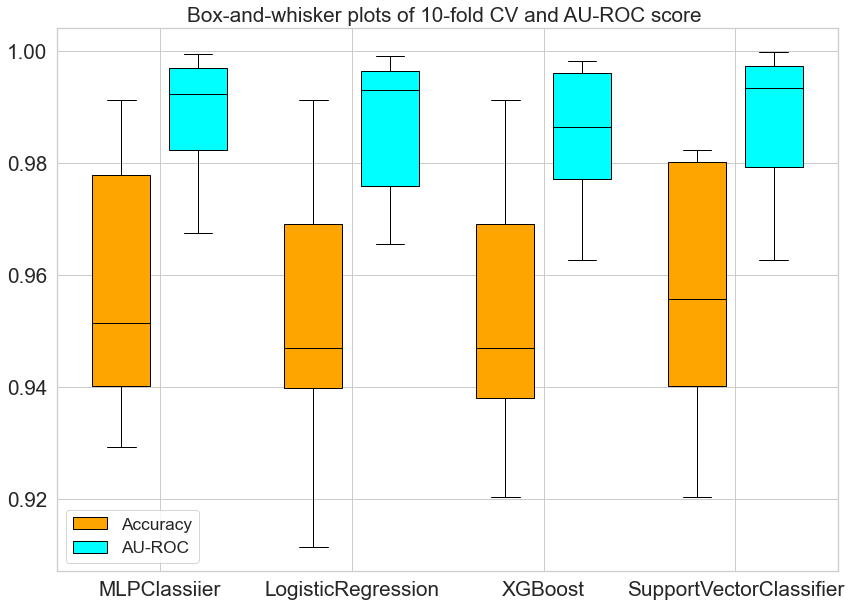

In [24]:
from matplotlib.patches import Patch

def draw_plot(data, offset, color):
    pos = np.arange(data.shape[1])+offset
#     edge_color = ['orange', 'cyan', 'gold', 'pink']
    edge_color = color
    bp = ax.boxplot(np.asarray(data), positions= pos, widths=0.3, patch_artist=True, manage_xticks=False)
    for i, patch in enumerate(bp['boxes']):
        patch.set(facecolor=edge_color)
    for i, patch in enumerate(bp['whiskers']):
        patch.set(color='black')
    for i, patch in enumerate(bp['medians']):
        patch.set(color='black')

# plt.figure(figsize=(14, 10))
color1 = 'orange'
color2 = 'cyan'
fig, ax = plt.subplots(figsize=(14, 10))
draw_plot(box_plot_prime, -0.2, color1)
draw_plot(box_plot_prime_auc, +0.2, color2)

legend_elements = [
    Patch(facecolor=color1, edgecolor='black', label='Accuracy'),
    Patch(facecolor=color2, edgecolor='black', label='AU-ROC')
]
ax.legend(handles=legend_elements, loc=3, fontsize='x-large')

plt.title('Box-and-whisker plots of 10-fold CV and AU-ROC score ', fontsize='xx-large')
plt.xticks([0, 1, 2, 3], ['MLPClassiier', 'LogisticRegression', 'XGBoost', 'SupportVectorClassifier'], fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.savefig(PATH+"/10_fold_accuracy_auroc_primary_dataset_UPDATED_LATEST", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
from matplotlib.patches import Patch

def draw_plot(data, offset, color):
    pos = np.arange(data.shape[1])+offset
#     edge_color = ['orange', 'cyan', 'gold', 'pink']
    edge_color = color
    bp = ax.boxplot(np.asarray(data), positions= pos, widths=0.3, patch_artist=True, manage_xticks=False)
    for i, patch in enumerate(bp['boxes']):
        patch.set(facecolor=edge_color)
    for i, patch in enumerate(bp['whiskers']):
        patch.set(color='black')
    for i, patch in enumerate(bp['medians']):
        patch.set(color='black')

# plt.figure(figsize=(14, 10))
color1 = 'lightgreen'
color2 = 'pink'
fig, ax = plt.subplots(figsize=(14, 10))
draw_plot(box_plot_indep, -0.2, color1)
draw_plot(box_plot_indep_auc, +0.2, color2)

legend_elements = [
    Patch(facecolor=color1, edgecolor='black', label='Accuracy'),
    Patch(facecolor=color2, edgecolor='black', label='AU-ROC')
]

#loc 3 is bottom left
#loc 4 is bottom right
ax.legend(handles=legend_elements, loc=4, fontsize='x-large')

plt.title('10-fold CV Accuracy and AU-ROC score of the ML models on independent dataset', fontsize='xx-large')
plt.xticks([0, 1, 2, 3], ['MLPClassiier', 'LogisticRegression', 'XGBoost', 'SupportVectorClassifier'], fontsize='xx-large')
plt.yticks(fontsize='x-large')
plt.savefig(PATH+"/10_fold_accuracy_auroc_independent_dataset", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# PLOT confusion matrix


In [ ]:
##  color: paired for mlp
## color: tab20_r for lr, svc
## color : viridis_r for xgb



## decided to show confusion matrix of only mlp  for primary dataset and svc for independent dataset

prime =[[445,  28],
 [22, 521]]

In [ ]:
sns.set(font_scale = 2)
sns.heatmap(prime, annot=True, fmt='d', center=0, cmap='tab20_r', xticklabels=['LUSC', 'LUAD'], yticklabels=['LUSC', 'LUAD'])
sns.set(font_scale = 1.5)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix of MLP on independent dataset using 10-Fold CV")
plt.savefig(PATH+"/confusion_mlp_indep", dpi=300, bbox_inches='tight')